# Run for Your Life — Marathons vs Life Expectancy
*Notebook generated on 2025-10-21. You should run and edit locally.*

**Goal:** Explore the relationship between a country's marathon activity and average life expectancy.

**Active Index** = `marathon_count / (population / 1_000_000)` (marathons per 1M people).

In [7]:
!pip install pycountry unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 18.2 MB/s eta 0:00:00


## 1) Sources & Citations
- **World Bank Indicators API** (Indicators & docs):
  - Indicators API docs: https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-about-the-indicators-api-documentation  
  - Life expectancy (SP.DYN.LE00.IN): https://data.worldbank.org/indicator/SP.DYN.LE00.IN  
  - Population (SP.POP.TOTL): https://data.worldbank.org/indicator/SP.POP.TOTL  
- **Wikidata Query Service (SPARQL endpoint):** https://query.wikidata.org/  
  - User manual: https://www.mediawiki.org/wiki/Wikidata_Query_Service/User_Manual  
- **Wikipedia (web scraping):**  
  - Category hub for marathons by country: https://en.wikipedia.org/wiki/Category:Marathons_by_country  
  - Regional list example (Asia): https://en.wikipedia.org/wiki/List_of_marathon_races_in_Asia  
  - Life expectancy table (cross-check): https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy  

**Ethics:** 1 request/sec for scraping; respect robots.txt; store raw snapshots; cite sources in your report.

## 2) Environment & Folders

In [8]:
# If missing locally, uncomment to install
# !pip install requests pandas beautifulsoup4 lxml pycountry unidecode matplotlib

import os, sys, platform, json, time, math
from datetime import datetime
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

print('Python:', platform.python_version())
print('Pandas:', pd.__version__)

RAW_DIR = 'data_raw'   # raw API/HTML snapshots
OUT_DIR = 'data_out'   # processed CSVs
FIG_DIR = 'figs'       # figures

for d in [RAW_DIR, OUT_DIR, FIG_DIR]:
    os.makedirs(d, exist_ok=True)

# Target year for snapshot; we will also pick latest non-null automatically
TARGET_YEAR = 2022


Python: 3.12.12
Pandas: 2.2.2


In [9]:
def save_json(obj, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def save_text(text, path):
    with open(path, 'w', encoding='utf-8') as f:
        f.write(text)

def latest_non_null(df, value_col='value', date_col='date', group_col='countryiso3code'):
    # df columns: [countryiso3code, country.value, indicator.id, date, value]
    # Keep latest non-null per country
    df2 = df.dropna(subset=[value_col]).copy()
    # date is a string year in WB; convert safely
    df2[date_col] = pd.to_numeric(df2[date_col], errors='coerce')
    df2 = df2.sort_values([group_col, date_col], ascending=[True, False])
    latest = df2.groupby(group_col, as_index=False).first()
    return latest

def gentle_get(url, params=None, headers=None, sleep=1.0):
    r = requests.get(url, params=params, headers=headers)
    r.raise_for_status()
    time.sleep(sleep)
    return r


## 3) World Bank API — Life Expectancy & Population
We fetch two indicators and keep the latest non-null value per country.

In [10]:
WB_BASE = 'https://api.worldbank.org/v2/country/all/indicator/{ind}'
INDICATORS = {
    'life_expectancy': 'SP.DYN.LE00.IN',
    'population': 'SP.POP.TOTL'
}

def fetch_wb_indicator(ind_code, per_page=20000):
    url = WB_BASE.format(ind=ind_code)
    params = {'format': 'json', 'per_page': per_page, 'page': 1}
    pages = 1
    all_data = []
    first = gentle_get(url, params=params)
    payload = first.json()
    if isinstance(payload, list) and len(payload) == 2:
        meta, data = payload
        pages = int(meta.get('pages', 1))
        all_data.extend(data)
    else:
        raise RuntimeError('Unexpected WB payload structure')

    for p in range(2, pages+1):
        params['page'] = p
        resp = gentle_get(url, params=params)
        payload = resp.json()
        _, data = payload
        all_data.extend(data)

    # Save raw
    save_json({'indicator': ind_code, 'data': all_data}, os.path.join(RAW_DIR, f'wb_{ind_code}.json'))
    # Normalize to dataframe
    rows = []
    for rec in all_data:
        rows.append({
            'countryiso3code': rec.get('countryiso3code'),
            'country_name': rec.get('country', {}).get('value'),
            'indicator': ind_code,
            'date': rec.get('date'),
            'value': rec.get('value')
        })
    df = pd.DataFrame(rows)
    return df

df_wb_le = fetch_wb_indicator(INDICATORS['life_expectancy'])
df_wb_pop = fetch_wb_indicator(INDICATORS['population'])

# Latest non-null snapshots
le_latest = latest_non_null(df_wb_le, value_col='value', date_col='date', group_col='countryiso3code')
le_latest = le_latest.rename(columns={'value': 'life_expectancy', 'country_name':'country_name_le'})
pop_latest = latest_non_null(df_wb_pop, value_col='value', date_col='date', group_col='countryiso3code')
pop_latest = pop_latest.rename(columns={'value': 'population', 'country_name':'country_name_pop'})

le_latest.to_csv(os.path.join(OUT_DIR, 'wb_life_expectancy_latest.csv'), index=False)
pop_latest.to_csv(os.path.join(OUT_DIR, 'wb_population_latest.csv'), index=False)

print('WB life expectancy (latest) rows:', len(le_latest))
print('WB population (latest) rows:', len(pop_latest))
le_latest.head()


WB life expectancy (latest) rows: 262
WB population (latest) rows: 262


,countryiso3code,country_name_le,indicator,date,life_expectancy
0,,High income,SP.DYN.LE00.IN,2023,80.150015
1,ABW,Aruba,SP.DYN.LE00.IN,2023,76.353000
2,AFE,Africa Eastern and Southern,SP.DYN.LE00.IN,2023,65.146291
3,AFG,Afghanistan,SP.DYN.LE00.IN,2023,66.035000
4,AFW,Africa Western and Central,SP.DYN.LE00.IN,2023,58.855722


## 4) Marathon Counts — Option B (API): Wikidata SPARQL
We count entities with `instance of (P31) = marathon (Q40244)` and resolve to countries.

In [11]:
SPARQL_ENDPOINT = 'https://query.wikidata.org/sparql'
SPARQL_QUERY = r'''
SELECT ?countryLabel (COUNT(?event) AS ?marathon_count)
WHERE {
  ?event wdt:P31 wd:Q40244 .           # event is a marathon
  OPTIONAL { ?event wdt:P17 ?country } # country of event if present
  OPTIONAL {
    ?event wdt:P131 ?adm .
    ?adm (wdt:P131)* ?country .        # ascend admin hierarchy to country
  }
  FILTER(BOUND(?country))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
GROUP BY ?countryLabel
ORDER BY DESC(?marathon_count)
'''
headers = {"Accept": "application/sparql-results+json", "User-Agent": "SIS-Student-Project/1.0"}
resp = gentle_get(SPARQL_ENDPOINT, params={'query': SPARQL_QUERY}, headers=headers)
data = resp.json()
save_json(data, os.path.join(RAW_DIR, 'wikidata_marathons.json'))

# Normalize
rows = []
for b in data['results']['bindings']:
    country = b['countryLabel']['value']
    count = int(b['marathon_count']['value'])
    rows.append({'country': country, 'marathon_count': count})
df_marathons = pd.DataFrame(rows).sort_values('marathon_count', ascending=False).reset_index(drop=True)
df_marathons.to_csv(os.path.join(OUT_DIR, 'marathon_counts_wikidata.csv'), index=False)

print('Wikidata marathon countries:', len(df_marathons))
df_marathons.head(12)


Wikidata marathon countries: 83


,country,marathon_count
0,United States,112
1,Germany,33
2,United Kingdom,24
3,Canada,22
4,India,17
5,Poland,15
6,Denmark,14
7,Russia,14
8,Japan,12
9,Italy,12


## 5) Marathon Counts — Option A (Scraping): Wikipedia category/list (Optional)
If you prefer scraping, parse one page (e.g., Asia list) and group by country.

In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

RAW_DIR = "raw"
OUT_DIR = "out"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

def gentle_get(url):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0 Safari/537.36"
        )
    }
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    return resp

def save_text(text, path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)

# Example: parse 'List of marathon races in Asia' table into country counts
WIKI_ASIA = "https://en.wikipedia.org/wiki/List_of_marathon_races_in_Asia"
html = gentle_get(WIKI_ASIA).text
save_text(html, os.path.join(RAW_DIR, "wiki_marathons_asia.html"))
soup = BeautifulSoup(html, "lxml")

# Try to read the first big table
tables = pd.read_html(html)
if tables:
    t0 = tables[0]
    # Expect columns like: Name | City / Race Location | Country | Month* | Inception | Ref
    # Clean and group by Country
    if "Country" in t0.columns:
        t0["Country"] = t0["Country"].astype(str).str.strip()
        df_marathons_asia = (
            t0.groupby("Country", as_index=False)
            .size()
            .rename(columns={"size": "marathon_count_asia"})
        )
        df_marathons_asia.to_csv(
            os.path.join(OUT_DIR, "marathon_counts_wiki_asia.csv"), index=False
        )
        print("Parsed Asia marathon table rows:", len(df_marathons_asia))
        display(df_marathons_asia.head(10))
    else:
        print("Warning: Unexpected table structure; inspect tables manually.")
else:
    print("No tables found on the page; inspect HTML manually.")



/tmp/ipython-input-3142163639.py:34: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


## 6) Country Normalization (to ISO3)
Normalize country names for merges. Keep an unmatched report.

In [13]:
import pycountry
from unidecode import unidecode
import os

def to_iso3(name: str):
    if not isinstance(name, str) or not name.strip():
        return None
    base = unidecode(name.strip())

    # quick fixes — исправлены все строки с апострофами
    fixes = {
        "Congo": "Congo, Republic of the",
        "DR Congo": "Congo, Democratic Republic of the",
        "Cote d'Ivoire": "Côte d'Ivoire",
        "Ivory Coast": "Côte d'Ivoire",
        "Russia": "Russian Federation",
        "Syria": "Syrian Arab Republic",
        "Iran": "Iran, Islamic Republic of",
        "Kyrgyzstan": "Kyrgyz Republic",
        "Vietnam": "Viet Nam",
        "Laos": "Lao People's Democratic Republic",
        "Bolivia": "Bolivia, Plurinational State of",
        "Venezuela": "Venezuela, Bolivarian Republic of",
        "Moldova": "Moldova, Republic of",
        "Tanzania": "Tanzania, United Republic of",
        "Micronesia": "Micronesia, Federated States of",
        "Cape Verde": "Cabo Verde",
        "Reunion": "Réunion",
        "South Korea": "Korea, Republic of",
        "North Korea": "Korea, Democratic People's Republic of",
        "United States": "United States of America"
    }

    base = fixes.get(base, base)

    # try by common name, official name, name
    for attr in ["name", "official_name", "common_name"]:
        try:
            for c in pycountry.countries:
                val = getattr(c, attr, None)
                if val and unidecode(val).lower() == base.lower():
                    return c.alpha_3
        except Exception:
            pass

    # try alpha_2/alpha_3 direct
    try:
        if len(base) == 2:
            return pycountry.countries.get(alpha_2=base.upper()).alpha_3
        if len(base) == 3:
            return pycountry.countries.get(alpha_3=base.upper()).alpha_3
    except Exception:
        pass

    return None


# Prepare frames with iso3
df_marathons["iso3"] = df_marathons["country"].apply(to_iso3)
le_latest["iso3"] = le_latest["countryiso3code"]
pop_latest["iso3"] = pop_latest["countryiso3code"]

unmatched = df_marathons[df_marathons["iso3"].isna()].copy()
unmatched.to_csv(os.path.join(OUT_DIR, "unmatched_marathon_countries.csv"), index=False)
print("Unmatched marathon countries:", len(unmatched))
unmatched.head(20)



Unmatched marathon countries: 9


,country,marathon_count,iso3
23,Turkey,3,None
41,State of Palestine,2,None
44,Saint-Denis,2,None
45,Seine-Saint-Denis,2,None
46,"arrondissement of Saint-Denis, Seine-Saint-Denis",2,None
47,Île-de-France,2,None
48,Metropolitan France,2,None
57,Socialist Federal Republic of Yugoslavia,1,None
81,Grand Paris,1,None


## 7) Merge & Feature Engineering
Join marathon counts with population & life expectancy; compute Active Index.

In [14]:
# Inner join to keep countries present in all datasets
df = (df_marathons.dropna(subset=['iso3'])
        .merge(pop_latest[['iso3','population','date']].rename(columns={'date':'pop_year'}),
               on='iso3', how='inner')
        .merge(le_latest[['iso3','life_expectancy','date']].rename(columns={'date':'le_year'}),
               on='iso3', how='inner'))

df['active_index'] = df['marathon_count'] / (df['population'] / 1_000_000.0)
df = df[['iso3','country','marathon_count','population','pop_year','life_expectancy','le_year','active_index']]
df = df.sort_values('active_index', ascending=False).reset_index(drop=True)

df.to_csv(os.path.join(OUT_DIR, 'run_for_your_life_master.csv'), index=False)
print('Merged rows:', len(df))
df.head(12)


Merged rows: 73


,iso3,country,marathon_count,population,pop_year,life_expectancy,le_year,active_index
0,GRL,Greenland,1,56836.0,2024,71.549756,2023,17.594482
1,ISL,Iceland,1,404610.0,2024,82.607317,2023,2.471516
2,DNK,Denmark,14,5976992.0,2024,81.853659,2023,2.342315
3,MNE,Montenegro,1,623831.0,2024,77.587805,2023,1.602998
4,LUX,Luxembourg,1,677717.0,2024,83.358537,2023,1.475542
5,CYP,Cyprus,2,1358282.0,2024,81.648000,2023,1.472448
6,EST,Estonia,2,1371986.0,2024,78.490244,2023,1.457741
7,NOR,Norway,8,5572272.0,2024,83.112195,2023,1.435680
8,LVA,Latvia,2,1862441.0,2024,75.678049,2023,1.073860
9,FIN,Finland,6,5637214.0,2024,81.685366,2023,1.064356


## 8) Visualizations
At least 3 clear charts. No seaborn; one chart per cell; no custom colors.

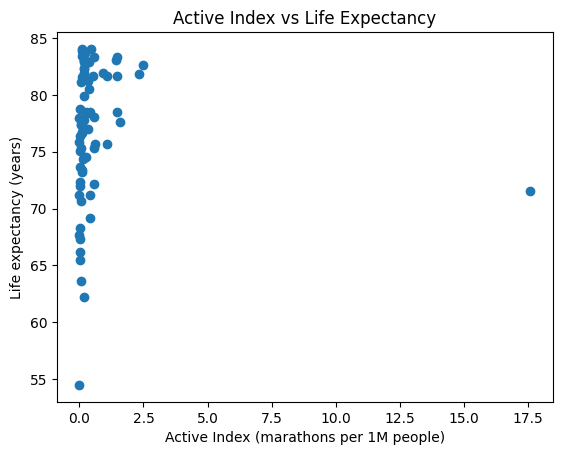

In [15]:
# Scatter: Active Index vs Life Expectancy
plt.figure()
plt.scatter(df['active_index'], df['life_expectancy'])
plt.xlabel('Active Index (marathons per 1M people)')
plt.ylabel('Life expectancy (years)')
plt.title('Active Index vs Life Expectancy')
plt.show()


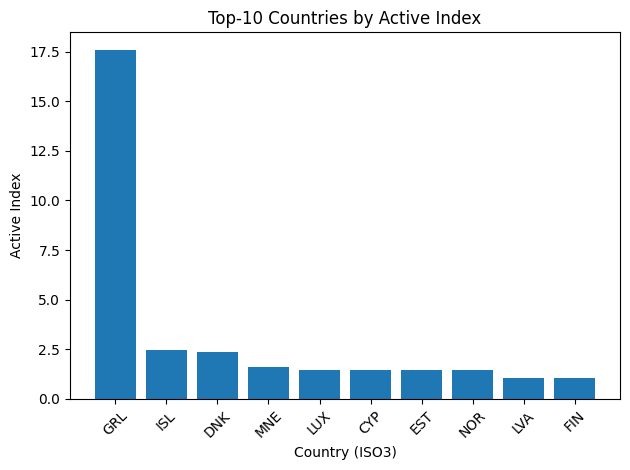

In [16]:
# Bar: Top-10 countries by Active Index
top10 = df.head(10).copy()
plt.figure()
plt.bar(top10['iso3'], top10['active_index'])
plt.xlabel('Country (ISO3)')
plt.ylabel('Active Index')
plt.title('Top-10 Countries by Active Index')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# (Optional) Regional heatmap-like summary without geo libs
# Compute simple region mapping using UN M49 via pycountry_convert if installed; else skip.
try:
    # !pip install pycountry-convert
    import pycountry_convert as pc

    def iso3_to_region(iso3):
        try:
            country = pycountry.countries.get(alpha_3=iso3)
            alpha2 = country.alpha_2
            continent_code = pc.country_alpha2_to_continent_code(alpha2)
            return continent_code
        except Exception:
            return None

    df['region'] = df['iso3'].apply(iso3_to_region)
    region_summary = df.groupby('region', as_index=False)['active_index'].mean().sort_values('active_index', ascending=False)
    print(region_summary)

    # Plot region summary as bar
    plt.figure()
    plt.bar(region_summary['region'], region_summary['active_index'])
    plt.xlabel('Region (Continent code)')
    plt.ylabel('Mean Active Index')
    plt.title('Average Active Index by Region')
    plt.show()
except Exception as e:
    print('Region summary skipped (pycountry-convert not available):', e)


Region summary skipped (pycountry-convert not available): No module named 'pycountry_convert'


## 9) Findings & Limitations (fill in after running)
- Describe 3–4 key insights from the scatter and top-10 chart.
- Note **correlation ≠ causation**; possible confounders (income, healthcare, urbanization, climate, tourism).
- Coverage bias of Wikidata/Wikipedia; temporal mismatch between event catalog and LE/Population year.
- Mention any outliers and hypotheses.


## 10) Save Artifacts
Export final CSV and figures for your report.

Saved figures to figs


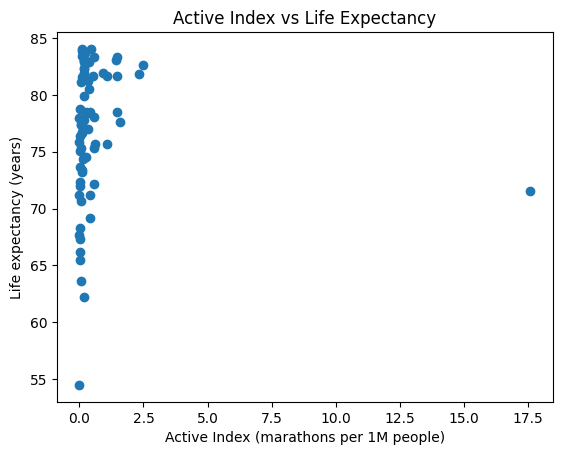

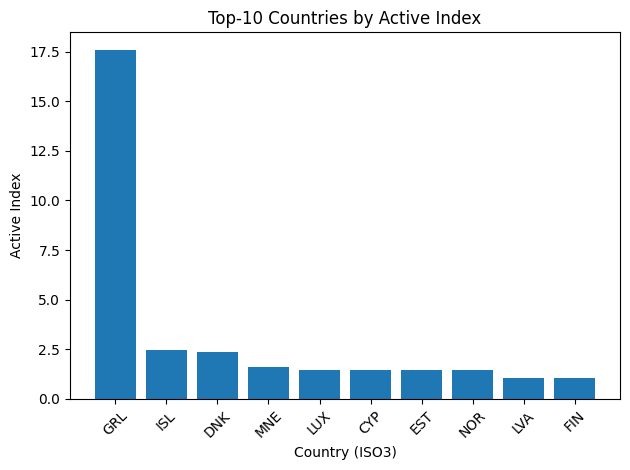

In [18]:
# Save example figures (re-run cells before saving if needed)
plt.figure()
plt.scatter(df['active_index'], df['life_expectancy'])
plt.xlabel('Active Index (marathons per 1M people)')
plt.ylabel('Life expectancy (years)')
plt.title('Active Index vs Life Expectancy')
plt.savefig(os.path.join(FIG_DIR, 'scatter_active_vs_le.png'))

top10 = df.head(10).copy()
plt.figure()
plt.bar(top10['iso3'], top10['active_index'])
plt.xlabel('Country (ISO3)')
plt.ylabel('Active Index')
plt.title('Top-10 Countries by Active Index')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'bar_top10_active_index.png'))

print('Saved figures to', FIG_DIR)


## Appendix — Wikipedia Life Expectancy Table (Optional)
Scrape the main table to compare values with World Bank snapshot.

In [19]:
WIKI_LE = 'https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy'
html_le = gentle_get(WIKI_LE).text
save_text(html_le, os.path.join(RAW_DIR, 'wiki_life_expectancy.html'))
tables_le = pd.read_html(html_le)
print('Found tables:', len(tables_le))
# Inspect first 1-2 tables manually after running


/tmp/ipython-input-3251485897.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_le = pd.read_html(html_le)


Found tables: 13
